# Text-Based Ideal Points using NumPyro

## ___Szymon Sacher & Keyon Vafa___ This notebook replicates Text-Based Ideal Point model (Vafa, Naidu & Blei, 2020)

This notebook is designed to run on Google Colab.

**IMPORTANT:** To save this code and your results, make sure you copy to your personal Google Drive. Under "File", select "Save a copy in Drive".

Use this Colab notebook to run a NumPyro implementation of the [text-based ideal point model (TBIP)](https://www.aclweb.org/anthology/2020.acl-main.475/) on a corpus of political text. The [Github repository is more complete](https://github.com/keyonvafa/tbip).

See also [Tensorflow implementation](https://colab.research.google.com/drive/1_KkVI2lGtPdgsHSKDIMhSLCKkHvBQ4LO#scrollTo=BLgkfNNZUZv5) on which this notebook is based.

The [TBIP](https://www.aclweb.org/anthology/2020.acl-main.475/) is an unsupervised probabilistic topic model that analyzes texts to quantify the political positions of its authors. The model does not use political parties or votes, nor does it require any text labelled by ideology. Given a corpus of political text and the authors of each document, the TBIP estimates the latent political positions of the authors of texts and how per-topic word choice changes as a function of the political position of the author ("ideological topics"). [Refer to the paper for more information](https://www.aclweb.org/anthology/2020.acl-main.475/).


## Getting started

First, **make sure you are running this Colab using a GPU**. Go to the "Runtime" menu, and click "Change runtime type". If the "Hardware accelerator" is listed as "None" or "TPU", change to "GPU". Click "Save" and you're ready to go. Also, as described in the first cell, make sure this code is copied to your personal Google Drive.

## Install NumPyro 

[NumPyro](https://github.com/pyro-ppl/numpyro) is a probabilistic programming framework powered by JAX for autograd and JIT compilation to GPU/TPU/CPU.



In [ ]:
%%capture
%pip install numpyro
#パッケージキャッシュが残っている場合の処方箋
#%pip uninstall -y numpyro
#%pip cache purge
#%pip install numpyro --no-cache-dir
%pip install optax

In [2]:
%load_ext watermark
%watermark -u -d -p torch,jax,numpyro,optax

Last updated: 2026-01-31

torch  : 2.9.0+cu126
jax    : 0.7.2
numpyro: 0.20.0
optax  : 0.2.6



In [7]:
import torch
torch.cuda.is_available()
print("CUDA is available:", torch.cuda.is_available())

CUDA is available: True


## Clone TBIP repository

Below we clone the [Github repo for the TBIP](https://github.com/keyonvafa/tbip). This is where the data resides.

In [8]:
!git clone https://github.com/keyonvafa/tbip

fatal: destination path 'tbip' already exists and is not an empty directory.


## Hyperparameters and Initialization

We start setting some hyperparameters. We fix the number of topics $K = 50$. We also set a random seed for reproducibility.

In [9]:
from jax import random

num_topics = 50
rng_seed = random.PRNGKey(0)

The next cell provides the data directory. The directory in the cell below links to speeches from the 114th Senate session from the `tbip` repo.

To use your own corpus, upload the following four files to the Colab working directory:

* `counts.npz`: a `[num_documents, num_words]` [sparse CSR matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) containing the word counts for each document.
* `author_indices.npy`: a `[num_documents]` vector where each entry is an integer in the set `{0, 1, ..., num_authors - 1}`, indicating the author of the corresponding document in `counts.npz`.
* `vocabulary.txt`: a `[num_words]`-length file where each line denotes the corresponding word in the vocabulary.
* `author_map.txt`: a `[num_authors]`-length file where each line denotes the name of an author in the corpus.

See [Senate speech clean data](https://github.com/keyonvafa/tbip/tree/master/data/senate-speeches-114/clean) for an example of what the four files look like for Senate speeches. [Our setup script](https://github.com/keyonvafa/tbip/blob/master/setup/senate_speeches_to_bag_of_words.py) 
contains example code for creating the four files from unprocessed data for Senate speeches.

**IMPORTANT:** If you are using your own corpus, change the following line to `data_dir = '.'` after uploading the four files to the Colab working directory.


In [10]:
import numpy as np
from scipy import sparse

import jax
import jax.numpy as jnp

dataPath = "tbip/data/senate-speeches-114/clean/"

# Load data
author_indices = jax.device_put(
    jnp.load(dataPath + "author_indices.npy"), jax.devices("gpu")[0]
)

counts = sparse.load_npz(dataPath + "counts.npz")

with open(dataPath + "vocabulary.txt", "r") as f:
    vocabulary = f.readlines()

with open(dataPath + "author_map.txt", "r") as f:
    author_map = f.readlines()

author_map = np.array(author_map)

num_authors = int(author_indices.max() + 1)
num_documents, num_words = counts.shape

[In the paper](https://www.aclweb.org/anthology/2020.acl-main.475/), the parameters are pre-initialized with [Poisson factorization](https://arxiv.org/abs/1311.1704). Most of the time, we find this doesn't make a big difference for the learned ideal points, but it helps to interpret the ideological topics. 

Below, we initialize with Scikit-Learn's non-negative matrix factorization (NMF) implementation. Although we find that Poisson factorization learns more interpretable topics, we use Scikit-Learn's NMF implementation here because it is faster. To use Poisson factorization, see the [code in the Github repo](https://github.com/keyonvafa/tbip/blob/master/setup/poisson_factorization.py). 

If you would like to skip this pre-initialization step, set `pre_initialize_parameters = False` in the cell below. (Pre-initialization is recommended.)

In [11]:
pre_initialize_parameters = True

In [12]:
# Fit NMF to be used as initialization for TBIP
from sklearn.decomposition import NMF

if pre_initialize_parameters:
    nmf_model = NMF(
        n_components=num_topics, init="random", random_state=0, max_iter=500
    )
    # Define initialization arrays
    initial_document_loc = jnp.log(
        jnp.array(np.float32(nmf_model.fit_transform(counts) + 1e-2))
    )
    initial_objective_topic_loc = jnp.log(
        jnp.array(np.float32(nmf_model.components_ + 1e-2))
    )
else:
    rng1, rng2 = random.split(rng_seed, 2)
    initial_document_loc = random.normal(rng1, shape=(num_documents, num_topics))
    initial_objective_topic_loc = random.normal(rng2, shape=(num_topics, num_words))

## Perform Inference

We perform inference using [variational inference](https://arxiv.org/abs/1601.00670) with [reparameterization](https://arxiv.org/abs/1312.6114) [gradients](https://arxiv.org/abs/1401.4082). We provide a brief summary below, but encourage readers to [refer to the original paper](https://www.aclweb.org/anthology/2020.acl-main.475/) for a more complete overview.

It is intractable to evaluate the posterior distribution $p(\theta, \beta, \eta, x | y)$, so we approximate the posterior with a distribution $q_\phi(\theta, \beta,\eta,x)$, parameterized by $\phi$. How do we set the values $\phi$? We want to minimize the KL-Divergence between $q$ and the posterior, which is equivalent to maximizing the ELBO:
$$\mathbb{E}_{q_\phi}[\log p(y, \theta, \beta, \eta, x) - \log q_{\phi}(\theta, \beta, \eta, x)].$$
We set the variational family to be the mean-field family, meaning the latent variables factorize over documents $d$, topics $k$, and authors $s$:
$$q_\phi(\theta, \beta, \eta, x) = \prod_{d,k,s} q(\theta_d)q(\beta_k)q(\eta_k)q(x_s).$$
We use lognormal factors for the positive variables and Gaussian factors for the real variables:
$$q(\theta_{dk}) = \text{LogNormal}(\mu_{\theta_{dk}}\sigma^2_{\theta_{dk}})$$
$$q(\beta{dv}) = \text{LogNormal}(\mu_{\beta_{kv}}, \sigma^2_{\beta_{kv}})$$
$$q(\eta_{kv}) = \text{Normal}(\mu_{\eta_{kv}}, \sigma^2_{\eta_{kv}})$$
$$q(x_s) = \text{Normal}(\mu_{x_s}, \sigma^2_{x_s}).$$

Thus, our goal is to maximize the ELBO with respect to $\phi = \{\mu_\theta, \sigma_\theta, \mu_\beta, \sigma_\beta,\mu_\eta, \sigma_\eta, \mu_x, \sigma_x\}$. 

In the cell below, we define the model and the variational family (guide).

In [13]:
from numpyro import param, plate, sample
import numpyro.distributions as dist
from numpyro.distributions import constraints

# Define the model and variational family


class TBIP:
    def __init__(self, N, D, K, V, batch_size, init_mu_theta=None, init_mu_beta=None):
        self.N = N  # number of people
        self.D = D  # number of documents
        self.K = K  # number of topics
        self.V = V  # number of words in vocabulary
        self.batch_size = batch_size  # number of documents in a batch

        if init_mu_theta is None:
            init_mu_theta = jnp.zeros([D, K])
        else:
            self.init_mu_theta = init_mu_theta

        if init_mu_beta is None:
            init_mu_beta = jnp.zeros([K, V])
        else:
            self.init_mu_beta = init_mu_beta

    def model(self, Y_batch, d_batch, i_batch):
        with plate("i", self.N):
            # Sample the per-unit latent variables (ideal points)
            x = sample("x", dist.Normal())

        with plate("k", size=self.K, dim=-2):
            with plate("k_v", size=self.V, dim=-1):
                beta = sample("beta", dist.Gamma(0.3, 0.3))
                eta = sample("eta", dist.Normal())

        with plate("d", size=self.D, subsample_size=self.batch_size, dim=-2):
            with plate("d_k", size=self.K, dim=-1):
                # Sample document-level latent variables (topic intensities)
                theta = sample("theta", dist.Gamma(0.3, 0.3))

            # Compute Poisson rates for each word
            P = jnp.sum(
                jnp.expand_dims(theta, 2)
                * jnp.expand_dims(beta, 0)
                * jnp.exp(
                    jnp.expand_dims(x[i_batch], (1, 2)) * jnp.expand_dims(eta, 0)
                ),
                1,
            )

            with plate("v", size=self.V, dim=-1):
                # Sample observed words
                sample("Y_batch", dist.Poisson(P), obs=Y_batch)

    def guide(self, Y_batch, d_batch, i_batch):
        # This defines variational family. Notice that each of the latent variables
        # defined in the sample statements in the model above has a corresponding
        # sample statement in the guide. The guide is responsible for providing
        # variational parameters for each of these latent variables.

        # Also notice it is required that model and the guide have the same call.

        mu_x = param(
            "mu_x", init_value=-1 + 2 * random.uniform(random.PRNGKey(1), (self.N,))
        )
        sigma_x = param(
            "sigma_y", init_value=jnp.ones([self.N]), constraint=constraints.positive
        )

        mu_eta = param(
            "mu_eta", init_value=random.normal(random.PRNGKey(2), (self.K, self.V))
        )
        sigma_eta = param(
            "sigma_eta",
            init_value=jnp.ones([self.K, self.V]),
            constraint=constraints.positive,
        )

        mu_theta = param("mu_theta", init_value=self.init_mu_theta)
        sigma_theta = param(
            "sigma_theta",
            init_value=jnp.ones([self.D, self.K]),
            constraint=constraints.positive,
        )

        mu_beta = param("mu_beta", init_value=self.init_mu_beta)
        sigma_beta = param(
            "sigma_beta",
            init_value=jnp.ones([self.K, self.V]),
            constraint=constraints.positive,
        )

        with plate("i", self.N):
            sample("x", dist.Normal(mu_x, sigma_x))

        with plate("k", size=self.K, dim=-2):
            with plate("k_v", size=self.V, dim=-1):
                sample("beta", dist.LogNormal(mu_beta, sigma_beta))
                sample("eta", dist.Normal(mu_eta, sigma_eta))

        with plate("d", size=self.D, subsample_size=self.batch_size, dim=-2):
            with plate("d_k", size=self.K, dim=-1):
                sample("theta", dist.LogNormal(mu_theta[d_batch], sigma_theta[d_batch]))

    def get_batch(self, rng, Y, author_indices):
        # Helper functions to obtain a batch of data, convert from scipy.sparse
        # to jax.numpy.array and move to gpu

        D_batch = random.choice(rng, jnp.arange(self.D), shape=(self.batch_size,))
        Y_batch = jax.device_put(jnp.array(Y[D_batch].toarray()), jax.devices("gpu")[0])
        D_batch = jax.device_put(D_batch, jax.devices("gpu")[0])
        I_batch = author_indices[D_batch]
        return Y_batch, I_batch, D_batch

## Initialization

Below we initialize an instance of the TBIP model, and associated SVI object. The latter is used to compute the Evidence Lower Bound (ELBO) given current value of guide's parameters and current batch of data.

We optimize the model using Adam with exponential decay of learning rate.  

In [14]:
# Initialize the model
from jax import jit
from optax import adam, exponential_decay

from numpyro.infer import SVI, TraceMeanField_ELBO

num_steps = 50000
batch_size = 512  # Large batches are recommended
learning_rate = 0.01
decay_rate = 0.01

tbip = TBIP(
    N=num_authors,
    D=num_documents,
    K=num_topics,
    V=num_words,
    batch_size=batch_size,
    init_mu_theta=initial_document_loc,
    init_mu_beta=initial_objective_topic_loc,
)

svi_batch = SVI(
    model=tbip.model,
    guide=tbip.guide,
    optim=adam(exponential_decay(learning_rate, num_steps, decay_rate)),
    loss=TraceMeanField_ELBO(),
)

# Compile update function for faster training
svi_batch_update = jit(svi_batch.update)

# Get initial batch. This informs the dimension of arrays and ensures they are
# consistent with dimensions (N, D, K, V) defined above.
Y_batch, I_batch, D_batch = tbip.get_batch(random.PRNGKey(1), counts, author_indices)

# Initialize the parameters using initial batch
svi_state = svi_batch.init(
    random.PRNGKey(0), Y_batch=Y_batch, d_batch=D_batch, i_batch=I_batch
)

In [15]:
# @title Run this cell to create helper function for printing topics


def get_topics(
    neutral_mean, negative_mean, positive_mean, vocabulary, print_to_terminal=True
):
    num_topics, num_words = neutral_mean.shape
    words_per_topic = 10
    top_neutral_words = np.argsort(-neutral_mean, axis=1)
    top_negative_words = np.argsort(-negative_mean, axis=1)
    top_positive_words = np.argsort(-positive_mean, axis=1)
    topic_strings = []
    for topic_idx in range(num_topics):
        neutral_start_string = "Neutral  {}:".format(topic_idx)
        neutral_row = [
            vocabulary[word] for word in top_neutral_words[topic_idx, :words_per_topic]
        ]
        neutral_row_string = ", ".join(neutral_row)
        neutral_string = " ".join([neutral_start_string, neutral_row_string])

        positive_start_string = "Positive {}:".format(topic_idx)
        positive_row = [
            vocabulary[word] for word in top_positive_words[topic_idx, :words_per_topic]
        ]
        positive_row_string = ", ".join(positive_row)
        positive_string = " ".join([positive_start_string, positive_row_string])

        negative_start_string = "Negative {}:".format(topic_idx)
        negative_row = [
            vocabulary[word] for word in top_negative_words[topic_idx, :words_per_topic]
        ]
        negative_row_string = ", ".join(negative_row)
        negative_string = " ".join([negative_start_string, negative_row_string])

        if print_to_terminal:
            topic_strings.append(negative_string)
            topic_strings.append(neutral_string)
            topic_strings.append(positive_string)
            topic_strings.append("==========")
        else:
            topic_strings.append(
                "  \n".join([negative_string, neutral_string, positive_string])
            )

    if print_to_terminal:
        all_topics = "{}\n".format(np.array(topic_strings))
    else:
        all_topics = np.array(topic_strings)
    return all_topics

## Execute Training
The code above was creating the model; below we actually run training. You can adjust the number of steps to train (`num_steps`, defined above) and the frequency at which to print the ELBO (`print_steps`, defined below).

Here, we run our training loop. Topic summaries and ordered ideal points will print every 2500 steps. Typically in our experiments it takes 15,000 steps or so to begin seeing sensible results, but of course this depends on the corpus. These sensible results should be reached within a half hour. For the default corpus of Senate speeches, it should take less than 2 hours to complete 30,000 training steps (which is the default `num_steps`). 

In [16]:
# Run SVI
import pandas as pd
from tqdm import tqdm

print_steps = 100
print_intermediate_results = False

rngs = random.split(random.PRNGKey(2), num_steps)
losses = []
pbar = tqdm(range(num_steps))


for step in pbar:
    Y_batch, I_batch, D_batch = tbip.get_batch(rngs[step], counts, author_indices)
    svi_state, loss = svi_batch_update(
        svi_state, Y_batch=Y_batch, d_batch=D_batch, i_batch=I_batch
    )

    loss = loss / counts.shape[0]
    losses.append(loss)
    if step % print_steps == 0 or step == num_steps - 1:
        pbar.set_description(
            "Init loss: "
            + "{:10.4f}".format(jnp.array(losses[0]))
            + f"; Avg loss (last {print_steps} iter): "
            + "{:10.4f}".format(jnp.array(losses[-100:]).mean())
        )

    if (step + 1) % 2500 == 0 or step == num_steps - 1:
        # Save intermediate results
        estimated_params = svi_batch.get_params(svi_state)

        neutral_mean = (
            estimated_params["mu_beta"] + estimated_params["sigma_beta"] ** 2 / 2
        )

        positive_mean = (
            estimated_params["mu_beta"]
            + estimated_params["mu_eta"]
            + (estimated_params["sigma_beta"] ** 2 + estimated_params["sigma_eta"] ** 2)
            / 2
        )

        negative_mean = (
            estimated_params["mu_beta"]
            - estimated_params["mu_eta"]
            + (estimated_params["sigma_beta"] ** 2 + estimated_params["sigma_eta"] ** 2)
            / 2
        )

        np.save("neutral_topic_mean.npy", neutral_mean)
        np.save("negative_topic_mean.npy", positive_mean)
        np.save("positive_topic_mean.npy", negative_mean)

        topics = get_topics(neutral_mean, positive_mean, negative_mean, vocabulary)

        with open("topics.txt", "w") as f:
            print(topics, file=f)

        authors = pd.DataFrame(
            {"name": author_map, "ideal_point": np.array(estimated_params["mu_x"])}
        )
        authors.to_csv("authors.csv")

        if print_intermediate_results:
            print(f"Results after {step} steps.")
            print(topics)
            sorted_authors = "Authors sorted by their ideal points: " + ",".join(
                list(authors.sort_values("ideal_point")["name"])
            )
            print(sorted_authors.replace("\n", " "))

Init loss: 35314.9531; Avg loss (last 100 iter):   630.7509: 100%|██████████| 50000/50000 [53:42<00:00, 15.52it/s]  


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

neutral_topic_mean = np.load("neutral_topic_mean.npy")
negative_topic_mean = np.load("negative_topic_mean.npy")
positive_topic_mean = np.load("positive_topic_mean.npy")
authors = pd.read_csv("authors.csv")
authors["name"] = authors["name"].str.replace("\n", "")

For example, here is a graph of the learned ideal points. We don't label each point because there are too many to plot. Below we select some authors to label.

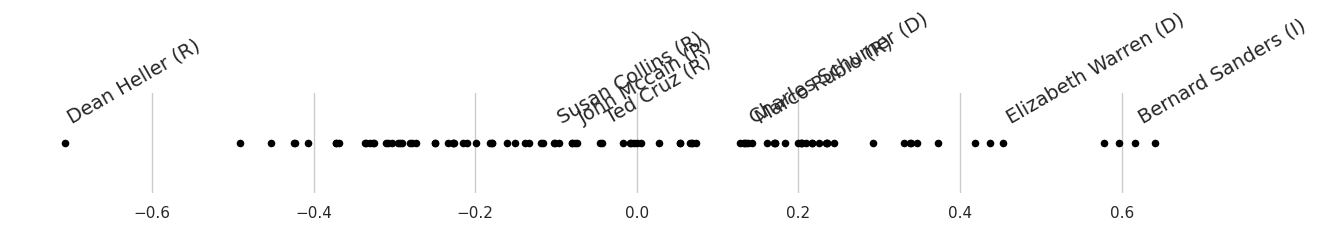

In [18]:
selected_authors = np.array(
    [
        "Dean Heller (R)",
        "Bernard Sanders (I)",
        "Elizabeth Warren (D)",
        "Charles Schumer (D)",
        "Susan Collins (R)",
        "Marco Rubio (R)",
        "John Mccain (R)",
        "Ted Cruz (R)",
    ]
)

sns.set(style="whitegrid")
fig = plt.figure(figsize=(12, 1))
ax = plt.axes([0, 0, 1, 1], frameon=False)
for index in range(authors.shape[0]):
    ax.scatter(authors["ideal_point"][index], 0, c="black", s=20)
    if authors["name"][index] in selected_authors:
        ax.annotate(
            author_map[index],
            xy=(authors["ideal_point"][index], 0.0),
            xytext=(authors["ideal_point"][index], 0),
            rotation=30,
            size=14,
        )
ax.set_yticks([])
plt.show()

## Automatic guide generation

Above, for pedagogical reasons, we defined the guide (i.e. Variational Family) manually, making sure it is identical to that descibed in the original paper. 

However, manually defining the guide is often unnecessary as NumPyro contains a [module](https://num.pyro.ai/en/stable/autoguide.html#id8) that enables automatic guide generation based on the model provided.

In our case it turns out that `AutoNormal` creates a guide that is identical to the one we manually defined above. Specifically it first transform variables to belong to unrestricted space of real numbers. For example, by applying the log transformation to those variables that are restricted to be non-negative (document locations $\theta_d$ and objective topic locations $\beta_j$). Then it uses independent Normal distribution as a guide for each transformed distribution.

In the cell below we verify that the guide generated by `AutoNormal` is in fact identical to the guide manually defined above as a part of the TBIP class.

In [19]:
from numpyro.infer.autoguide import AutoNormal


def create_svi_object(guide):
    SVI(
        model=tbip.model,
        guide=guide,
        optim=adam(exponential_decay(learning_rate, num_steps, decay_rate)),
        loss=TraceMeanField_ELBO(),
    )

    Y_batch, I_batch, D_batch = tbip.get_batch(
        random.PRNGKey(1), counts, author_indices
    )

    svi_state = svi_batch.init(
        random.PRNGKey(0), Y_batch=Y_batch, d_batch=D_batch, i_batch=I_batch
    )

    return svi_state


# This state uses the guide defined manually above
svi_state_manualguide = create_svi_object(guide=tbip.guide)

# Now let's create this object but using AutoNormal guide. We just need to ensure that
# parameters are initialized as above.
autoguide = AutoNormal(
    model=tbip.model,
    init_loc_fn={"beta": initial_objective_topic_loc, "theta": initial_document_loc},
)
svi_state_autoguide = create_svi_object(guide=autoguide)


# Assert that the keys in the optimizer states are identical
assert svi_state_manualguide[0][1][0].keys() == svi_state_autoguide[0][1][0].keys()

# Assert that the values in the optimizer states are identical
for key in svi_state_manualguide[0][1][0].keys():
    assert jnp.all(
        svi_state_manualguide[0][1][0][key] == svi_state_autoguide[0][1][0][key]
    )